In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [5]:
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df.head()
#https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data/data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

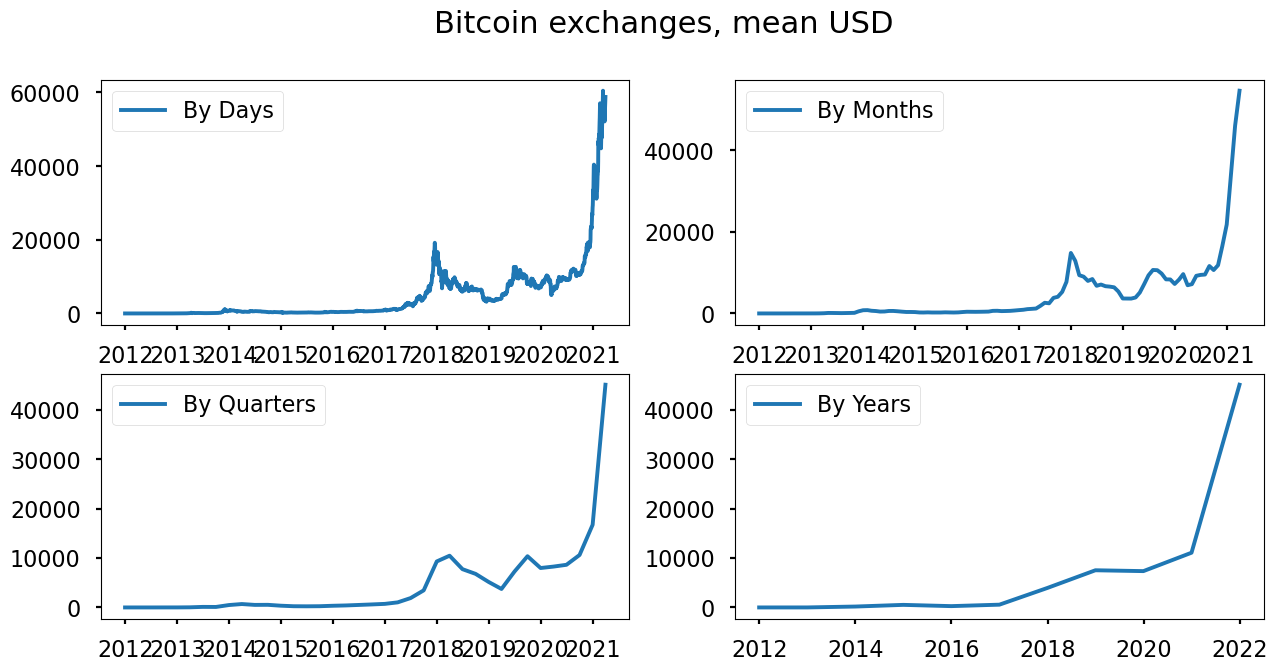

In [7]:
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

Dickey–Fuller test: p=0.998863


<Figure size 1500x700 with 0 Axes>

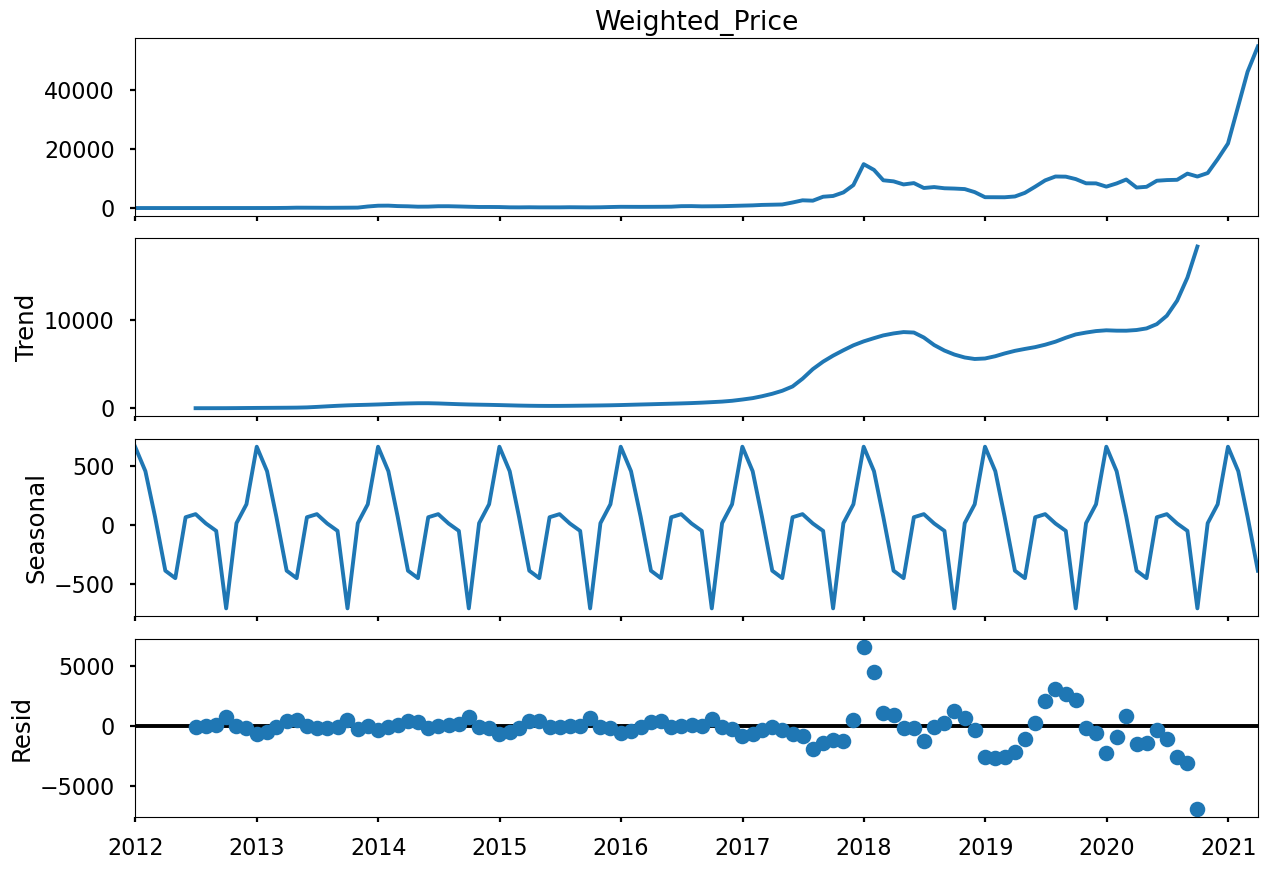

In [8]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

In [9]:
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

Dickey–Fuller test: p=0.998863


In [10]:
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.444282


Dickey–Fuller test: p=0.000024


<Figure size 1500x700 with 0 Axes>

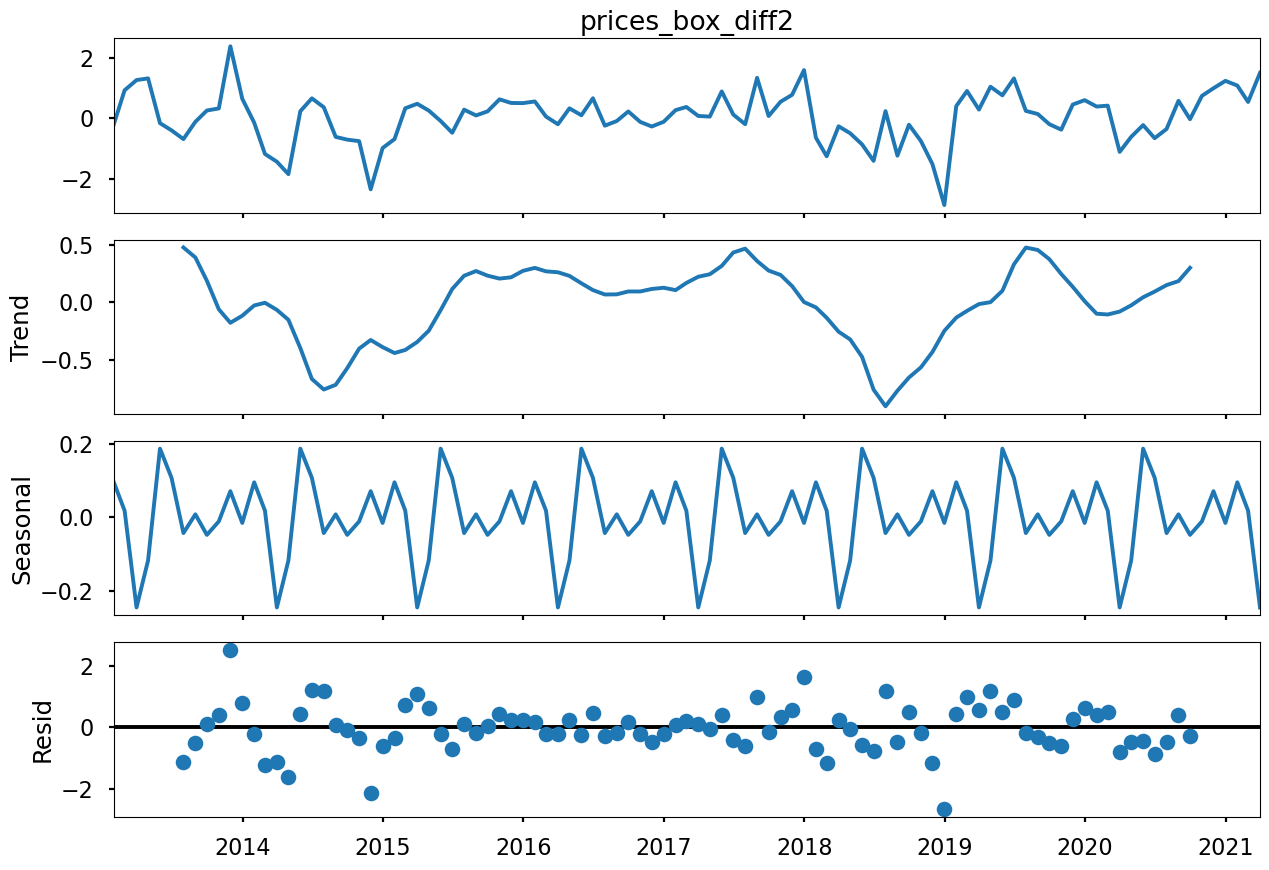

In [11]:
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

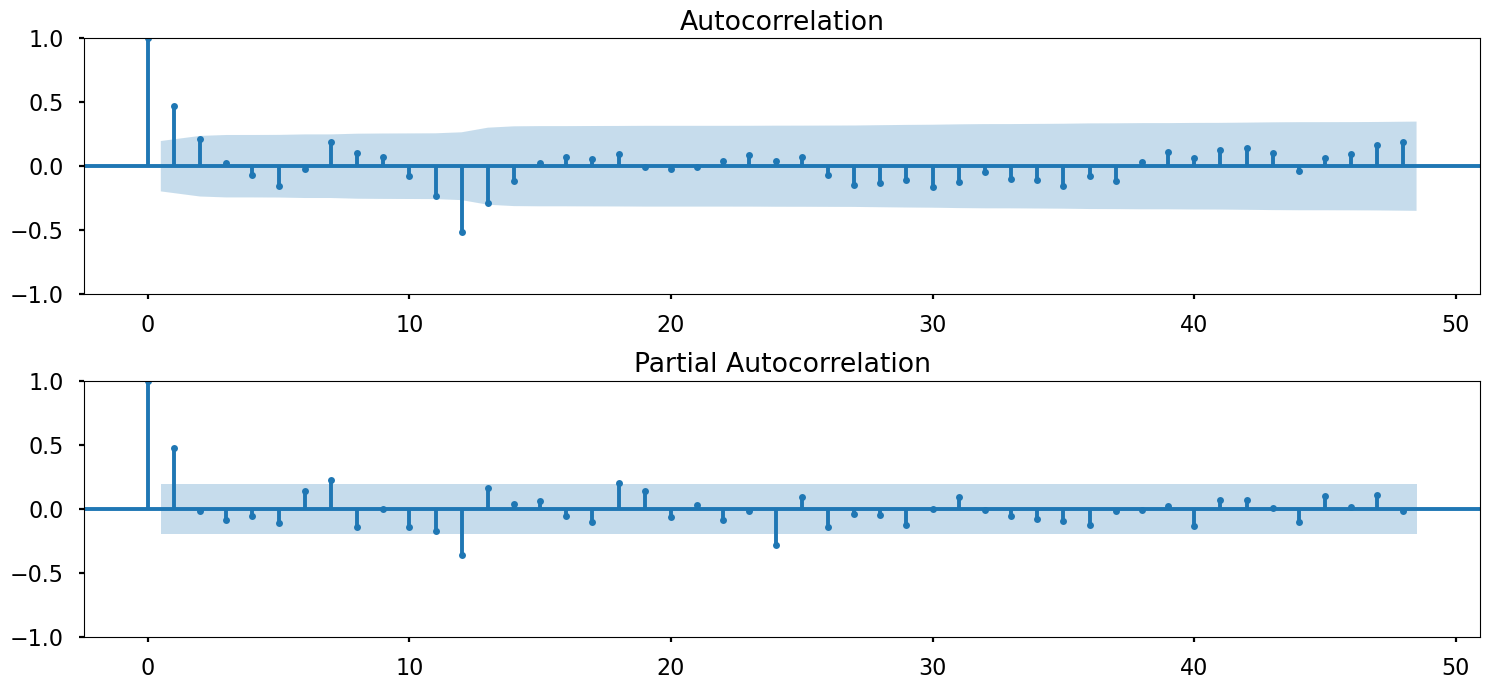

In [12]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [13]:
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [14]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  173.615881
21  (1, 0, 1, 1)  174.766384
25  (1, 1, 0, 1)  175.547421
37  (2, 0, 0, 1)  175.554347
7   (0, 1, 0, 1)  175.589248
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                  112
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -83.808
Date:                              Mon, 15 Jan 2024   AIC                            173.616
Time:                                      21:05:02   BIC                            181.401
Sample:                                  12-31-2011   HQIC                           176.766
                                       - 03-31-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

Dickey–Fuller test:: p=0.000000


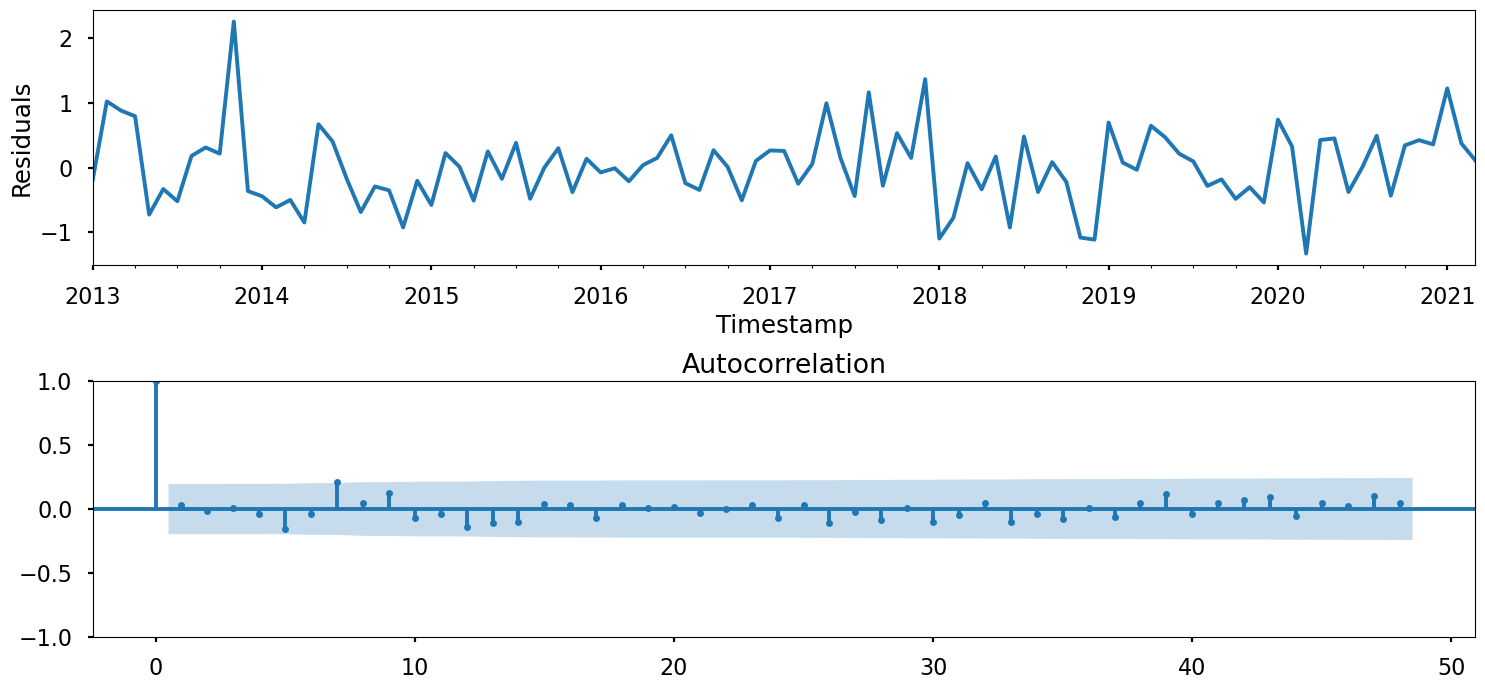

In [15]:
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [16]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

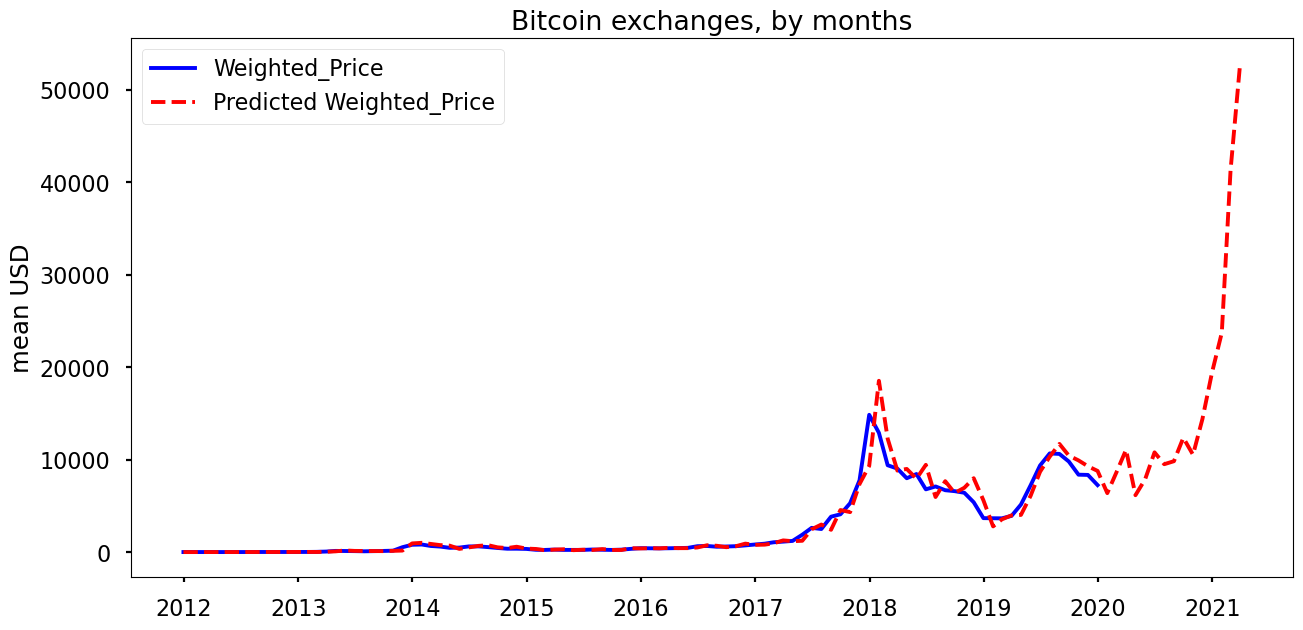

In [80]:
# Assuming df_month is your original DataFrame
df_month2 = df_month[['Weighted_Price']]

# Update date_list for prediction from 2018 to 2026
date_list = [
    datetime(2018, 1, 1), datetime(2018, 2, 1), datetime(2018, 3, 1), datetime(2018, 4, 1),
    datetime(2018, 5, 1), datetime(2018, 6, 1), datetime(2018, 7, 1), datetime(2018, 8, 1),
    datetime(2018, 9, 1), datetime(2018, 10, 1), datetime(2018, 11, 1), datetime(2018, 12, 1),
    datetime(2019, 1, 1), datetime(2019, 2, 1), datetime(2019, 3, 1), datetime(2019, 4, 1),
    datetime(2019, 5, 1), datetime(2019, 6, 1), datetime(2019, 7, 1), datetime(2019, 8, 1),
    datetime(2019, 9, 1), datetime(2019, 10, 1), datetime(2019, 11, 1), datetime(2019, 12, 1),
    datetime(2020, 1, 1), datetime(2020, 2, 1), datetime(2020, 3, 1), datetime(2020, 4, 1),
    datetime(2020, 5, 1), datetime(2020, 6, 1), datetime(2020, 7, 1), datetime(2020, 8, 1),
    datetime(2020, 9, 1), datetime(2020, 10, 1), datetime(2020, 11, 1), datetime(2020, 12, 1),
    datetime(2021, 1, 1), datetime(2021, 2, 1), datetime(2021, 3, 1), datetime(2021, 4, 1),
    datetime(2021, 5, 1), datetime(2021, 6, 1), datetime(2021, 7, 1), datetime(2021, 8, 1),
    datetime(2021, 9, 1), datetime(2021, 10, 1), datetime(2021, 11, 1), datetime(2021, 12, 1),
    datetime(2022, 1, 1), datetime(2022, 2, 1), datetime(2022, 3, 1), datetime(2022, 4, 1),
    datetime(2022, 5, 1), datetime(2022, 6, 1), datetime(2022, 7, 1), datetime(2022, 8, 1),
    datetime(2022, 9, 1), datetime(2022, 10, 1), datetime(2022, 11, 1), datetime(2022, 12, 1),
    datetime(2023, 1, 1), datetime(2023, 2, 1), datetime(2023, 3, 1), datetime(2023, 4, 1),
    datetime(2023, 5, 1), datetime(2023, 6, 1), datetime(2023, 7, 1), datetime(2023, 8, 1),
    datetime(2023, 9, 1), datetime(2023, 10, 1), datetime(2023, 11, 1), datetime(2023, 12, 1),
    datetime(2024, 1, 1), datetime(2024, 2, 1), datetime(2024, 3, 1), datetime(2024, 4, 1),
    datetime(2024, 5, 1), datetime(2024, 6, 1), datetime(2024, 7, 1), datetime(2024, 8, 1),
    datetime(2024, 9, 1), datetime(2024, 10, 1), datetime(2024, 11, 1), datetime(2024, 12, 1),
    datetime(2025, 1, 1), datetime(2025, 2, 1), datetime(2025, 3, 1), datetime(2025, 4, 1),
    datetime(2025, 5, 1), datetime(2025, 6, 1), datetime(2025, 7, 1), datetime(2025, 8, 1),
    datetime(2025, 9, 1), datetime(2025, 10, 1), datetime(2025, 11, 1), datetime(2025, 12, 1),
    datetime(2026, 1, 1), datetime(2026, 2, 1), datetime(2026, 3, 1), datetime(2026, 4, 1),
    datetime(2026, 5, 1), datetime(2026, 6, 1), datetime(2026, 7, 1), datetime(2026, 8, 1),
    datetime(2026, 9, 1), datetime(2026, 10, 1), datetime(2026, 11, 1), datetime(2026, 12, 1),
]

# Create a DataFrame for future dates
future = pd.DataFrame(index=date_list, columns=df_month.columns)

# Concatenate the original DataFrame and the future DataFrame
df_month2 = pd.concat([df_month2, future])

# Assuming best_model is the ARIMA model you have already trained
# Update the prediction start and end based on the new length of df_month2
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=len(df_month2) - 1), lmbda)

# Plot the results
plt.figure(figsize=(15, 7))
plt.plot(df_month2[df_month2.index.year <= 2019].Weighted_Price, label='Weighted_Price', color='blue')
plt.plot(df_month2['forecast'], label='Predicted Weighted_Price', color='red', ls='--')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()
